## Brain Tumor Classification

The task is to use classification algorithms to categorize 4 types of brain tumors.

 * Glioma Tumor
 * Meningioma Tumor
 * No Tumor
 * Pituitary Tumor

**Dataset:** [click here](https://www.kaggle.com/datasets/prathamgrover/brain-tumor-classification/download?datasetVersionNumber=1) to download the images

###  1. Import the necessary libraries

In [39]:
import os
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torchvision import transforms, datasets
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [3]:
# Define data transformations (you can customize these)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.RandomHorizontalFlip(),  # Data augmentation: random horizontal flip
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

In [10]:
# Define train and test data directory
TRAIN_IMG_DIR = 'Data\Brain-Tumor\Training'
TEST_IMG_DIR = 'Data\Brain-Tumor\Testing'

In [11]:
# Load the dataset
train_dataset = datasets.ImageFolder(TRAIN_IMG_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_IMG_DIR, transform=transform)

In [12]:
def display_random_images(data_dir):
    # Get a list of subfolders (tumor class types)
    subfolders = os.listdir(data_dir)
    
    # Create a subplot for each subfolder
    num_subplots = len(subfolders)
    rows, cols = 2, 4  # 2 rows and 4 columns for each subplot
    fig, axes = plt.subplots(rows, cols, figsize=(8, 4))
    
    # Iterate through each subfolder
    for i, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(data_dir, subfolder)
        image_files = os.listdir(subfolder_path)
        
        # Randomly select 8 images from the subfolder
        selected_images = random.sample(image_files, 8)
        
        # Create a subplot for the current subfolder
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        # Display the tumor class type as the subplot title
        ax.set_title(subfolder)
        
        # Display the selected images in the subplot
        for image_file in selected_images:
            image_path = os.path.join(subfolder_path, image_file)
            img = Image.open(image_path)
            ax.imshow(img)
            ax.axis('off')  # Turn off axis labels
            
    # Remove any empty subplots (if there are fewer subfolders than subplots)
    for i in range(num_subplots, rows * cols):
        fig.delaxes(axes.flatten()[i])
    
    # Adjust subplot layout and display
    plt.tight_layout()
    plt.show()

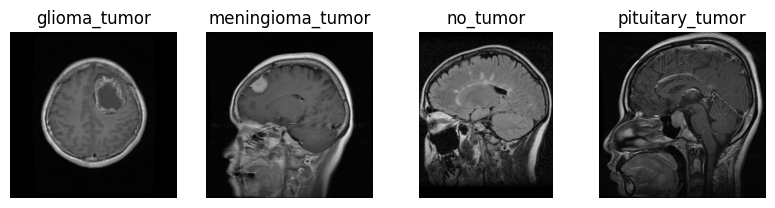

In [13]:
display_random_images(TRAIN_IMG_DIR)

In [14]:
def display_random_images_in_row(data_dir, num_images=8):
    # Get a list of subfolder names in the data directory
    subfolders = [subfolder for subfolder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subfolder))]

    # Loop through each subfolder
    for subfolder in subfolders:
        # Define the path to the tumor subfolder within the "Training" folder
        subfolder_path = os.path.join(data_dir, subfolder)
        print(f'Images path : {subfolder_path}')
        
        # Get a list of image files in the subfolder
        image_files = os.listdir(subfolder_path)
        
        # Randomly select 'num_images' images from the subfolder
        selected_images = random.sample(image_files, num_images)
        
        # Create a horizontal row for displaying the images
        fig, axes = plt.subplots(1, num_images, figsize=(16, 4))

        # Display the selected images in the row
        for i, image_file in enumerate(selected_images):
            image_path = os.path.join(subfolder_path, image_file)
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')  # Turn off axis labels

        # Add a title at the bottom of the row using plt.title()
        plt.suptitle(f'Images for class: {subfolder}', fontsize=18, fontweight='bold', y=0.8)
            
        
        # Adjust subplot layout
        plt.tight_layout()
        
        # Display the plot
        plt.show()

images path : Data\Brain-Tumor\Training\glioma_tumor


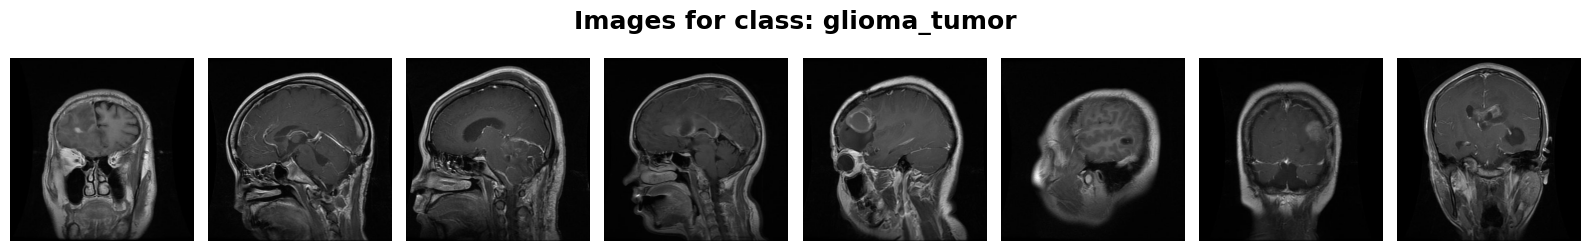

images path : Data\Brain-Tumor\Training\meningioma_tumor


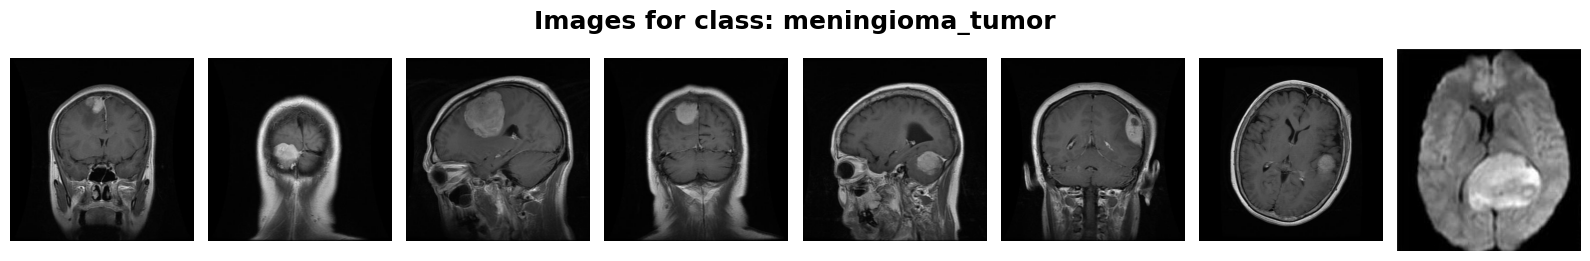

images path : Data\Brain-Tumor\Training\no_tumor


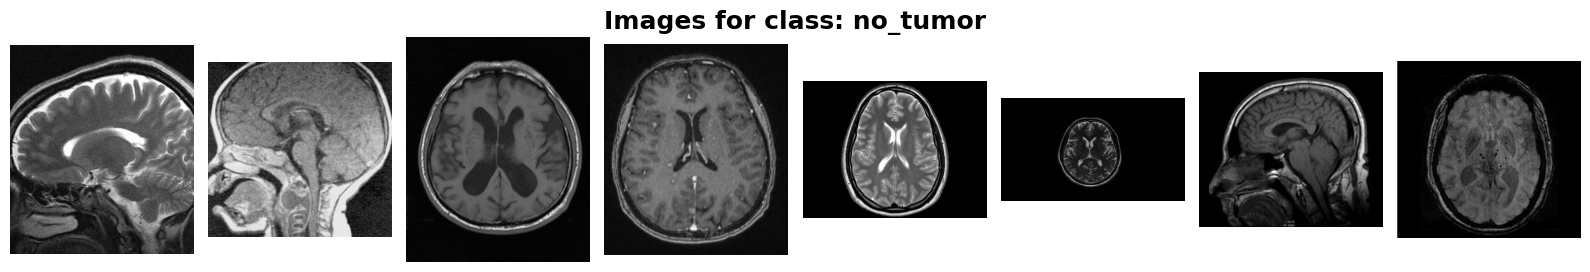

images path : Data\Brain-Tumor\Training\pituitary_tumor


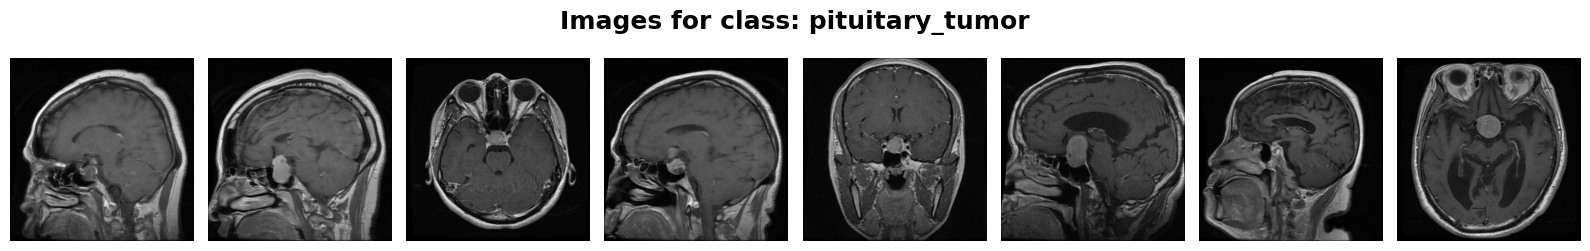

In [15]:
display_random_images_in_row(TRAIN_IMG_DIR)

### 2. Load and preprocess the data

In [25]:
# Define data transformations for train and test datasets.
# These transformations include resizing, random cropping, random horizontal flipping, and normalization.
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop and resize the image to 224x224 pixels.
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally for data augmentation.
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image using precomputed mean and standard deviation.
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels.
        transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels.
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image using precomputed mean and standard deviation.
    ]),
}

In [26]:
# Specify the root directory where your data is stored.
data_dir = "Data/Brain-Tumor" # Update with the path to your data directory

In [28]:
# Create datasets for both train and test data using ImageFolder.
# ImageFolder automatically organizes your data into classes based on subfolders.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}

In [29]:
# Create data loaders for train and test datasets.
# Data loaders allow you to load data in batches for training and testing.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['Training', 'Testing']}

In [30]:
# Calculate the size of the datasets (number of samples) for train and test.
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}

In [31]:
# Get the class names based on the subfolders in the 'train' directory.
class_names = image_datasets['Training'].classes
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

### 3. Load the pretrained ResNet-50 model

In [35]:
model_ft = torchvision.models.resnet50(pretrained=True)

D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\thaku/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
39.4%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To

### 4. Modify the final fully connected layer

In [36]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

### 5. Define loss function and optimizer

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

### 6. Train the model

In [42]:
# Define a function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                model.train() # Set the model to training mode.
            else:
                model.eval()  # Set the model to evaluation mode.
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'Training':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

# Determine whether a CUDA-capable GPU is available, and set the device accordingly.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device (GPU or CPU).
model_ft = model_ft.to(device)

# Define the optimizer for training the model.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler that adjusts the learning rate during training.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# In this scheduler, the learning rate is reduced by a factor of 0.1 every 7 epochs.

# Train the model using the train_model function with the specified parameters.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
Training Loss: 0.8275 Acc: 0.6672
Testing Loss: 1.3590 Acc: 0.5203

Epoch 1/29
----------
Training Loss: 0.4051 Acc: 0.8463
Testing Loss: 1.4239 Acc: 0.6320

Epoch 2/29
----------
Training Loss: 0.3039 Acc: 0.8875
Testing Loss: 1.3591 Acc: 0.6726

Epoch 3/29
----------
Training Loss: 0.2577 Acc: 0.9045
Testing Loss: 1.1371 Acc: 0.7310

Epoch 4/29
----------
Training Loss: 0.2317 Acc: 0.9146
Testing Loss: 1.2114 Acc: 0.7563

Epoch 5/29
----------
Training Loss: 0.1837 Acc: 0.9282
Testing Loss: 1.1500 Acc: 0.7513

Epoch 6/29
----------
Training Loss: 0.1741 Acc: 0.9355
Testing Loss: 1.2193 Acc: 0.7487

Epoch 7/29
----------
Training Loss: 0.1681 Acc: 0.9331
Testing Loss: 1.2406 Acc: 0.7513

Epoch 8/29
----------
Training Loss: 0.1408 Acc: 0.9519
Testing Loss: 1.2324 Acc: 0.7589

Epoch 9/29
----------
Training Loss: 0.1491 Acc: 0.9425
Testing Loss: 1.1798 Acc: 0.7589

Epoch 10/29
----------
Training Loss: 0.1300 Acc: 0.9495
Testing Loss: 1.3386 Acc: 0.7589

Epoch 11/

### 7. Evaluate the model

In [43]:
# Set the model to evaluation mode
model_ft.eval()

# Initialize variables to keep track of correct predictions and total samples
correct = 0
total = 0

# Disable gradient calculation for evaluation to save memory and computation
with torch.no_grad():
    # Iterate through batches in the test data loader
    for inputs, labels in dataloaders['Testing']:
        # Move inputs and labels to the selected device (GPU or CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass: compute model predictions
        outputs = model_ft(inputs)
        
        # Get the class with the highest probability as the predicted class
        _, predicted = torch.max(outputs.data, 1)
        
        # Update the total count of samples
        total += labels.size(0)
        
        # Update the count of correct predictions
        correct += (predicted == labels).sum().item()

# Calculate and print the test accuracy
test_accuracy = 100 * correct / total
print('Test accuracy: {:.2f}%'.format(test_accuracy))

Test accuracy: 77.16%


### 8. Saving the Trained Model

In [44]:
# Save the trained model to a file
torch.save(model_ft.state_dict(), 'brain_tumor_model.pth')